In [42]:
cd /home/kingsman/Escritorio/PhD/Main/Lenstronomy


/home/kingsman/Escritorio/PhD/Main/Lenstronomy


/home/kingsman/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Inspección del dataset

Este será el conjunto de datos con los que se entrenará al doble-autoencoder.
La primera imagen será la entrada del mismo; las otras dos serán los targets que queremos emular.

In [43]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F



Available datasets: ['delta_psi_maps', 'images_noisy', 'images_smooth', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_noisy shape: (10000, 100, 100)
images_smooth shape: (10000, 100, 100)
delta_psi_maps shape: (10000, 100, 100)
subhalo_mass shape: (10000,)
subhalo_x shape: (10000,)
subhalo_y shape: (10000,)
Plotting samples: [8837 9508 5895]


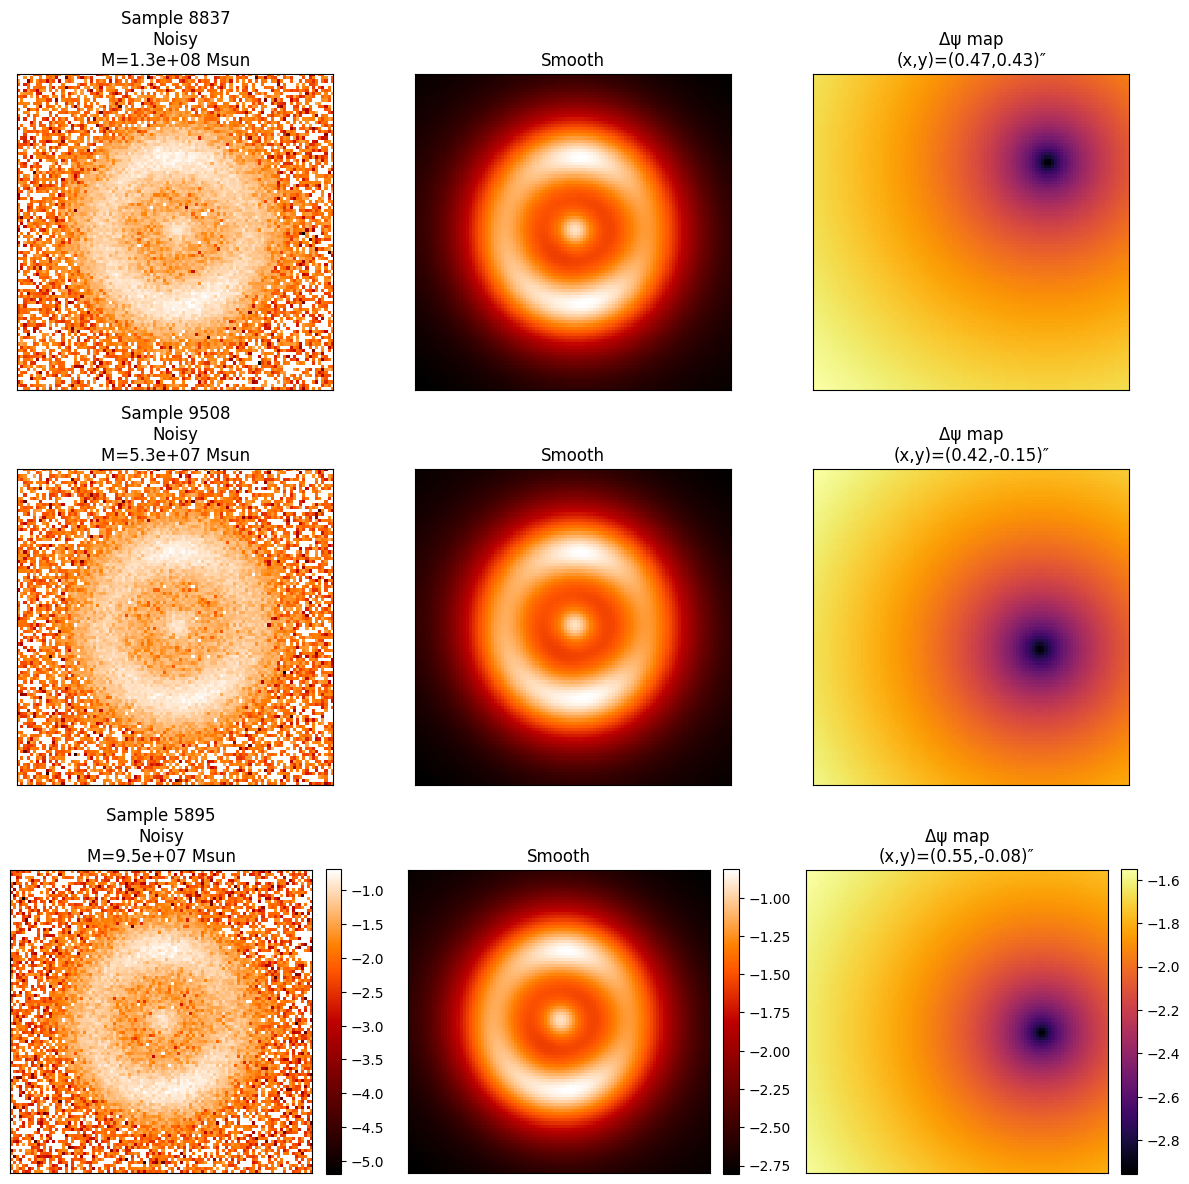

In [44]:

# Path to your HDF5 file
h5_path = 'lens_10k_no_sc.h5'

# Open the file and inspect
with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_noisy shape:", f['images_noisy'].shape)
    print("images_smooth shape:", f['images_smooth'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_noisy'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Plot each sample as a row of three panels
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
    for row, idx in enumerate(sample_indices):
        img_noisy   = f['images_noisy'][idx]
        img_smooth  = f['images_smooth'][idx]
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: Noisy image
        im0 = axes[row, 0].imshow(img_noisy, origin='lower', cmap='gist_heat')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy\nM={mass:.1e} Msun")
        # Panel 2: Smooth target
        im1 = axes[row, 1].imshow(img_smooth, origin='lower', cmap='gist_heat')
        axes[row, 1].set_title("Smooth")
        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='inferno')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Add colorbars only on the last row (or adjust as desired)
        if row == 2:
            fig.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


### 1: Read the dataset from the HDF5 file


In [45]:
# 1) Load the data from the HDF5 file
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_noisy'][:]    # (N, H, W)
    Y_smooth = f['images_smooth'][:]   # (N, H, W)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W)
    sub_mass = f['subhalo_mass'][:]  # (N,)
    sub_x    = f['subhalo_x'][:]     # (N,)
    sub_y    = f['subhalo_y'][:]     # (N,)

### Step 2: Pre-processing

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.



In [46]:
# 2) Clean the data.
# Convert NaNs and infinities to zero, if necessary.
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)
sub_mass = np.nan_to_num(sub_mass, nan=0.0, posinf=None, neginf=None)
sub_x    = np.nan_to_num(sub_x,    nan=0.0, posinf=None, neginf=None)
sub_y    = np.nan_to_num(sub_y,    nan=0.0, posinf=None, neginf=None)
   
# 3) Split the data into training and validation sets.
# add 1 dimension to the images 
X  = torch.from_numpy(X_noisy).float().unsqueeze(1)  # (N,1,H,W)
Y1 = torch.from_numpy(Y_smooth).float().unsqueeze(1) 
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)


In [47]:
# Split dataset into train, validation, and test sets
idx = np.arange(X.shape[0])
# 10% test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)
# val 20/90 = ~22.22% 
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

#Images split
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

#mass and coordinates split
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]  


In [48]:
# 6) Normalize the data.
mean_X,  std_X  = X_train.mean(),  X_train.std()
mean_Y1, std_Y1 = Y1_train.mean(), Y1_train.std()
mean_Y2, std_Y2 = Y2_train.mean(), Y2_train.std()
mean_mass, std_mass = sub_mass_train.mean(), sub_mass_train.std()
mean_x, std_x = sub_x_train.mean(), sub_x_train.std()
mean_y, std_y = sub_y_train.mean(), sub_y_train.std()   

def normalize(t, m, s):
    return (t - m) / s

X_train = normalize(X_train, mean_X,  std_X)
X_val   = normalize(X_val,   mean_X,  std_X)
X_test  = normalize(X_test,  mean_X,  std_X)

Y1_train = normalize(Y1_train, mean_Y1, std_Y1)
Y1_val   = normalize(Y1_val,   mean_Y1, std_Y1)
Y1_test  = normalize(Y1_test,  mean_Y1, std_Y1)

Y2_train = normalize(Y2_train, mean_Y2, std_Y2)
Y2_val   = normalize(Y2_val,   mean_Y2, std_Y2)
Y2_test  = normalize(Y2_test,  mean_Y2, std_Y2)

sub_mass_train = normalize(sub_mass_train, mean_mass, std_mass)
sub_mass_val   = normalize(sub_mass_val,   mean_mass, std_mass)
sub_mass_test  = normalize(sub_mass_test,  mean_mass, std_mass)

sub_x_train = normalize(sub_x_train, mean_x, std_x)
sub_x_val   = normalize(sub_x_val,   mean_x, std_x)
sub_x_test  = normalize(sub_x_test,  mean_x, std_x)

sub_y_train = normalize(sub_y_train, mean_y, std_y)
sub_y_val   = normalize(sub_y_val,   mean_y, std_y)
sub_y_test  = normalize(sub_y_test,  mean_y, std_y)


In [49]:
#Datasats for training, witg shape (N, 3)
mxy_train = torch.tensor(np.array([sub_mass_train, sub_x_train, sub_y_train])).float().T  # (N, 3)
mxy_val   = torch.tensor(np.array([sub_mass_val, sub_x_val, sub_y_val])).float().T
mxy_test  = torch.tensor(np.array([sub_mass_test, sub_x_test, sub_y_test])).float().T   

In [50]:
# 7) Dataset y DataLoader
batch = 32  # Tamaño del batch

# 1) Empaquetamos directamente los tensores en un TensorDataset
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val, mxy_val)

# 2) Creamos los DataLoader igual que antes
train_loader = DataLoader(
    train_ds,
    batch_size=batch,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch,
    shuffle=False,
    num_workers=4
)
# 3) Opcional: DataLoader para test
test_ds = TensorDataset(X_test, Y1_test, Y2_test, mxy_test)
test_loader = DataLoader(
    test_ds,
    batch_size=batch,
    shuffle=False,
    num_workers=4
)

### Step 8: Model Definition

**Device detection**  
We select GPU if available, otherwise CPU:  
$$
\text{device} = \texttt{cuda}\;\text{if available else}\;\texttt{cpu}.
$$

**Shared encoder**  
The encoder $E$ repeatedly applies 2D convolutions with stride 2 to downsample:
$$
x \in \mathbb{R}^{1\times100\times100}
\;\xrightarrow{\;\text{Conv2d}(1\to16,\,3\times3,\,s=2)\;}\;
16\times36\times50
\;\xrightarrow{\;\text{Conv2d}(16\to32,\,3\times3,\,s=2)\;}\;
32\times25\times25
\;\xrightarrow{\;\text{Conv2d}(32\to64,\,3\times3,\,s=2)\;}\;
64\times13\times13
$$
Formally, the encoder is a mapping
$$
E: \mathbb{R}^{1\times100\times100} \;\longrightarrow\; \mathbb{R}^{64\times13\times13}.
$$

**Two parallel decoders**  
Each decoder $D$ uses transposed convolutions to invert the downsampling:
$$
64\times13\times13
\;\xrightarrow{\;\text{ConvTranspose2d}(64\to32,\,3\times3,\,s=2)\;}\;
32\times25\times25
\;\xrightarrow{\;\text{ConvTranspose2d}(32\to16,\,3\times3,\,s=2)\;}\;
16\times50\times50
\;\xrightarrow{\;\text{ConvTranspose2d}(16\to1,\,3\times3,\,s=2)\;}\;
1\times100\times100
$$
We define:
- **Decoder for smooth image**: $\hat Y_{\text{smooth}} = D_{1}(z)$.  
- **Decoder for $\Delta\psi$ map**: $\hat Y_{\Delta\psi} = D_{2}(z)$.

**Complete network**  
The full model is
$$
z = E(x),\quad
\bigl(\hat Y_{\text{smooth}}, \,\hat Y_{\Delta\psi}\bigr)
= \bigl(D_{1}(z),\,D_{2}(z)\bigr),
$$
with input $x\in\mathbb{R}^{1\times100\times100}$ and outputs in the same shape.


In [51]:
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [52]:

# class DualVAE(nn.Module):
#     def __init__(self, in_ch=1, base_ch=16, z_dim=128, H=100, W=100):
#         super().__init__()
#         # ————————————————— Encoder convolucional —————————————————
#         self.enc1 = nn.Sequential(
#             nn.Conv2d(in_ch, base_ch, 3, 2, 1), nn.ReLU()
#         )
#         self.enc2 = nn.Sequential(
#             nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), nn.ReLU()
#         )
#         self.enc3 = nn.Sequential(
#             nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU()
#         )

#         # Calcula dinámicamente tamaño espacial tras cada conv
#         def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
#         H1, W1 = conv_out(H),   conv_out(W)
#         H2, W2 = conv_out(H1),  conv_out(W1)
#         H3, W3 = conv_out(H2),  conv_out(W2)

#         # Guarda las dimensiones del bottleneck feature map
#         self._C3 = 4 * base_ch
#         self._H3 = H3
#         self._W3 = W3
#         feat_dim  = self._C3 * H3 * W3

#         # ————————————— VAE: μ y logσ² —————————————
#         self.fc_feat = nn.Linear(feat_dim, 2*z_dim)
#         self.z_dim   = z_dim

#         # ——————— Decoder prep: de z a feature‐map ——————
#         self.fc_dec = nn.Linear(z_dim, feat_dim)

#         # ————————————————— Helpers U-Net —————————————————
#         def up_block(ch_in, ch_out, opad):
#             return nn.Sequential(
#                 nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, output_padding=opad),
#                 nn.ReLU()
#             )
#         def mix_block(ch_in, ch_out):
#             return nn.Sequential(
#                 nn.Conv2d(ch_in, ch_out, 3, padding=1),
#                 nn.ReLU()
#             )

#         # ————————————— Decoder “suave” —————————————
#         self.up1s = up_block(self._C3,      self._C3//2, opad=0)
#         self.mix1s= mix_block(self._C3//2 + self._C3//2, self._C3//2)
#         self.up2s = up_block(self._C3//2,   base_ch,     opad=1)
#         self.mix2s= mix_block(base_ch + base_ch,        base_ch)
#         self.up3s = nn.ConvTranspose2d(base_ch, 1, 3, 2, 1, output_padding=1)

#         # ————————————— Decoder Δψ (idéntico) —————————————
#         self.up1d = up_block(self._C3,      self._C3//2, opad=0)
#         self.mix1d= mix_block(self._C3//2 + self._C3//2, self._C3//2)
#         self.up2d = up_block(self._C3//2,   base_ch,     opad=1)
#         self.mix2d= mix_block(base_ch + base_ch,        base_ch)
#         self.up3d = nn.ConvTranspose2d(base_ch, 1, 3, 2, 1, output_padding=1)

#     def encode(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(e1)
#         e3 = self.enc3(e2)
#         h  = e3.view(e3.size(0), -1)
#         stats = self.fc_feat(h)
#         mu, logvar = stats.chunk(2, dim=1)
#         return mu, logvar, e1, e2

#     def reparameterize(self, mu, logvar):
#         std = (0.5*logvar).exp()
#         eps = torch.randn_like(std)
#         return mu + eps*std

#     def decode(self, z, e1, e2):
#         h = self.fc_dec(z)
#         N = h.size(0)
#         # Usamos las dimensiones guardadas para el reshape
#         h = h.view(N, self._C3, self._H3, self._W3)

#         # Smooth branch con skip e2,e1
#         u1s = self.up1s(h)
#         m1s = self.mix1s(torch.cat([u1s, e2], dim=1))
#         u2s = self.up2s(m1s)
#         m2s = self.mix2s(torch.cat([u2s, e1], dim=1))
#         out_s = self.up3s(m2s)

#         # Delta branch
#         u1d = self.up1d(h)
#         m1d = self.mix1d(torch.cat([u1d, e2], dim=1))
#         u2d = self.up2d(m1d)
#         m2d = self.mix2d(torch.cat([u2d, e1], dim=1))
#         out_d = self.up3d(m2d)

#         return out_s, out_d

#     def forward(self, x):
#         mu, logvar, e1, e2 = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         s, d = self.decode(z, e1, e2)
#         return s, d, mu, logvar


In [53]:
# class DualVAE(nn.Module):
#     def __init__(self, in_ch=1, base_ch=16, z_dim=128, H=100, W=100):
#         super().__init__()
#         # ————————————————— Encoder convolucional —————————————————
#         # igual que antes, solo 3 conv+ReLU con stride=2 → H/8×W/8
#         self.enc = nn.Sequential(
#             nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(),
#             nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(),
#             nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU()
#         )

#         # calcula H3,W3 tras esas 3 convs
#         def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
#         H1, W1 = conv_out(H),    conv_out(W)
#         H2, W2 = conv_out(H1),   conv_out(W1)
#         H3, W3 = conv_out(H2),   conv_out(W2)

#         self._C3 = 4 * base_ch
#         self._H3 = H3
#         self._W3 = W3
#         feat_dim = self._C3 * H3 * W3

#         # ————————————— VAE: μ y logσ² —————————————
#         self.fc_mu     = nn.Linear(feat_dim, z_dim)
#         self.fc_logvar = nn.Linear(feat_dim, z_dim)

#         # ——————— Decoder base: de z a feature‐map ——————
#         self.fc_dec = nn.Linear(z_dim, feat_dim)

#         # ————————————————— Decoder suave —————————————————
#         self.decoder_s = nn.Sequential(
#             nn.ReLU(),
#             nn.Unflatten(1, (self._C3, self._H3, self._W3)),
#             nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=0), nn.ReLU(),
#             nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1), nn.ReLU(),
#             nn.ConvTranspose2d(base_ch,      1,           3, 2, 1, output_padding=1)
#         )

#         # ————————————————— Decoder Δψ —————————————————
#         self.decoder_d = nn.Sequential(
#             nn.ReLU(),
#             nn.Unflatten(1, (self._C3, self._H3, self._W3)),
#             nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=0), nn.ReLU(),
#             nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1), nn.ReLU(),
#             nn.ConvTranspose2d(base_ch,      1,           3, 2, 1, output_padding=1)
#         )

#     def encode(self, x):
#         h = self.enc(x)
#         h = h.view(h.size(0), -1)
#         mu, logvar = self.fc_mu(h), self.fc_logvar(h)
#         return mu, logvar

#     def reparameterize(self, mu, logvar):
#         std = (0.5 * logvar).exp()
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h = self.fc_dec(z)
#         s = self.decoder_s(h)
#         d = self.decoder_d(h)
#         return s, d

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         s, d = self.decode(z)
#         return s, d, mu, logvar


In [54]:
#Encoder con la reconstrucción de las imagenes, masas y posiciones

class DualVAE(nn.Module):
    def __init__(self, in_ch=1, base_ch=16, z_dim=128, H=100, W=100):
        super().__init__()
        # ————————————————— Encoder convolucional —————————————————
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(),nn.Dropout(0.3),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(),nn.Dropout(0.3),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(),nn.Dropout(0.3),
        )

        # cálculo dinámico de H3,W3 tras 3 convs
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)
        H2, W2 = conv_out(H1),   conv_out(W1)
        H3, W3 = conv_out(H2),   conv_out(W2)

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ————————————— VAE: μ y logσ² —————————————
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——————— Decoder prep: de z a feature‐map ——————
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # ————————————————— Decoders —————————————————
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=0), nn.ReLU(), nn.Dropout(0.3),
            nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1), nn.ReLU(),nn.Dropout(0.3),
            nn.ConvTranspose2d(base_ch,      1,           3, 2, 1, output_padding=1)
        )
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=0), nn.ReLU(),nn.Dropout(0.3),
            nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1), nn.ReLU(),nn.Dropout(0.3),
            nn.ConvTranspose2d(base_ch,      1,           3, 2, 1, output_padding=1)
        )

        # ————————————— Regresión conjunta masa,x,y —————————————
        # Un solo linear de z_dim → 3
        # self.fc_regs = nn.Linear(z_dim, 3)
        self.fc_regs =  nn.Sequential(
    nn.Linear(z_dim, z_dim//2),
    nn.Tanh(), nn.Dropout(0.1),
    nn.Linear(z_dim//2, 3))

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)
        d = self.decoder_d(h)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        # Cabezal conjunto para [masa, xpos, ypos]
        mxy_pred = self.fc_regs(mu)  # shape (batch_size, 3)
        return s, d, mu, logvar, mxy_pred


In [55]:
# 3) Instanciar VAE dual, función de pérdida combinada y optimizador

# 3.1) Modelo VAE en lugar de la U-Net determinista
model = DualVAE(
    in_ch=1,        # un canal de entrada
    base_ch=20,     # ancho base (igual que antes)
    z_dim=128,      # dimensión del espacio latente
    H=100, W=100    # tamaño de tus imágenes
).to(device)

# # 3.2) Pérdida: MSE(smooth) + α·MSE(delta) + β·KL
# def vae_loss(s_pred, s_true, d_pred, d_true, mu, logvar,
#              alpha=1.0, beta=1e-3):
#     # Reconstrucción pixel-a-pixel
#     mse = F.mse_loss(s_pred, s_true) + alpha * F.mse_loss(d_pred, d_true)
#     # KL divergence normalizada por batch size
#     kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / s_pred.size(0)
#     return mse + beta * kl

# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,  # learning rate
    weight_decay=1e-4
)

In [56]:
# import torch.nn.functional as F

# # 1) Pérdida combinada VAE + regresión
# def total_loss(s_pred, s_true,
#                d_pred, d_true,
#                mu, logvar,
#                mxy_pred, mxy_true,
#                alpha=1.0, beta=1e-3, gamma=1.0):
#     # 1.1) Reconstrucción VAE
#     recon = F.mse_loss(s_pred,  s_true) \
#           + alpha * F.mse_loss(d_pred, d_true)
#     kl    = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     kl   /= s_pred.size(0)
#     vae_l = recon + beta * kl

#     # 1.2) Regresión masa,xpos,ypos (MSE conjunta)
#     reg_l = F.mse_loss(mxy_pred, mxy_true)

#     return vae_l + gamma * reg_l


# # 2) train_epoch adaptado
# def train_epoch(loader, optimizer,
#                 alpha=1.0, beta=1e-3, gamma=1.0):
#     model.train()
#     total_loss = 0.0
#     for x, y_s, y_d, mxy in loader:
#         x, y_s, y_d, mxy = [t.to(device) for t in (x, y_s, y_d, mxy)]

#         optimizer.zero_grad()
#         # forward: ahora devolvemos mxy_pred también
#         p_s, p_d, mu, logvar, mxy_pred = model(x)

#         loss = total_loss(
#             p_s,      y_s,
#             p_d,      y_d,
#             mu,       logvar,
#             mxy_pred, mxy,
#             alpha, beta, gamma
#         )
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()

#         total_loss += loss.item() * x.size(0)

#     return total_loss / len(loader.dataset)


# # 3) eval_epoch adaptado
# def eval_epoch(loader,
#                alpha=1.0, beta=1e-3, gamma=1.0):
#     model.eval()
#     total_loss = 0.0
#     with torch.no_grad():
#         for x, y_s, y_d, mxy in loader:
#             x, y_s, y_d, mxy = [t.to(device) for t in (x, y_s, y_d, mxy)]
#             p_s, p_d, mu, logvar, mxy_pred = model(x)

#             loss = total_loss(
#                 p_s,      y_s,
#                 p_d,      y_d,
#                 mu,       logvar,
#                 mxy_pred, mxy,
#                 alpha, beta, gamma
#             )
#             total_loss += loss.item() * x.size(0)

#     return total_loss / len(loader.dataset)


In [57]:
# 1) Renombra la función de pérdida combinada para evitar confusiones
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    # VAE recon + KL
    recon = F.mse_loss(s_pred, s_true) + alpha*F.mse_loss(d_pred, d_true)
    kl    = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl   /= s_pred.size(0)
    vae_l = recon + beta * kl

    # regresión conjunta m,x,y
    reg_l = F.mse_loss(mxy_pred, mxy_true)

    return vae_l + gamma * reg_l

# 2) Actualiza train_epoch y eval_epoch
def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0):
    model.train()
    running_loss = 0.0
    for x, y_s, y_d, mxy in loader:
        x, y_s, y_d, mxy = [t.to(device) for t in (x, y_s, y_d, mxy)]
        optimizer.zero_grad()
        p_s, p_d, mu, logvar, mxy_pred = model(x)
        loss = combined_loss(
            p_s, y_s,
            p_d, y_d,
            mu, logvar,
            mxy_pred, mxy,
            alpha, beta, gamma
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x, y_s, y_d, mxy = [t.to(device) for t in (x, y_s, y_d, mxy)]
            p_s, p_d, mu, logvar, mxy_pred = model(x)
            loss = combined_loss(
                p_s, y_s,
                p_d, y_d,
                mu, logvar,
                mxy_pred, mxy,
                alpha, beta, gamma
            )
            running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

# 3) El loop principal
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

num_epochs = 30
alpha = 1.0
beta  = 1e-3
gamma = 1.0

train_losses = []
val_losses   = []

# barra de época más ancha
outer_bar = trange(1, num_epochs+1, desc="Epoch", ncols=100, dynamic_ncols=False, colour="#47def8")

for epoch in outer_bar:
    # barra interna por batch
    batch_bar = tqdm(train_loader,
                     desc=f"  Train {epoch:03d}",
                     ncols=200,
                     leave=False)
    running = 0.0
    for x, y_s, y_d, mxy in batch_bar:
        x, y_s, y_d, mxy = [t.to(device) for t in (x, y_s, y_d, mxy)]
        optimizer.zero_grad()
        p_s, p_d, mu, logvar, mxy_pred = model(x)
        loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                             alpha, beta, gamma)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running += loss.item() * x.size(0)
        batch_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running / len(train_loader.dataset)
    train_losses.append(train_loss)

    val_loss = eval_epoch(val_loader, alpha, beta, gamma)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")



Epoch: 100%|██████████████████████████████| 30/30 [02:49<00:00,  5.66s/it, train=0.0412, val=0.0942]


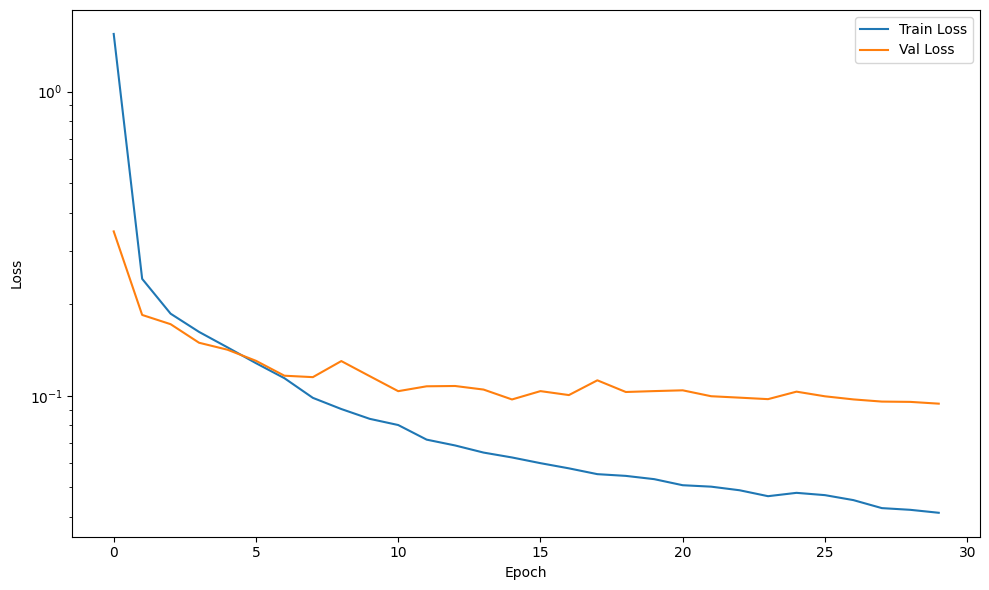

In [58]:
# plot final
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


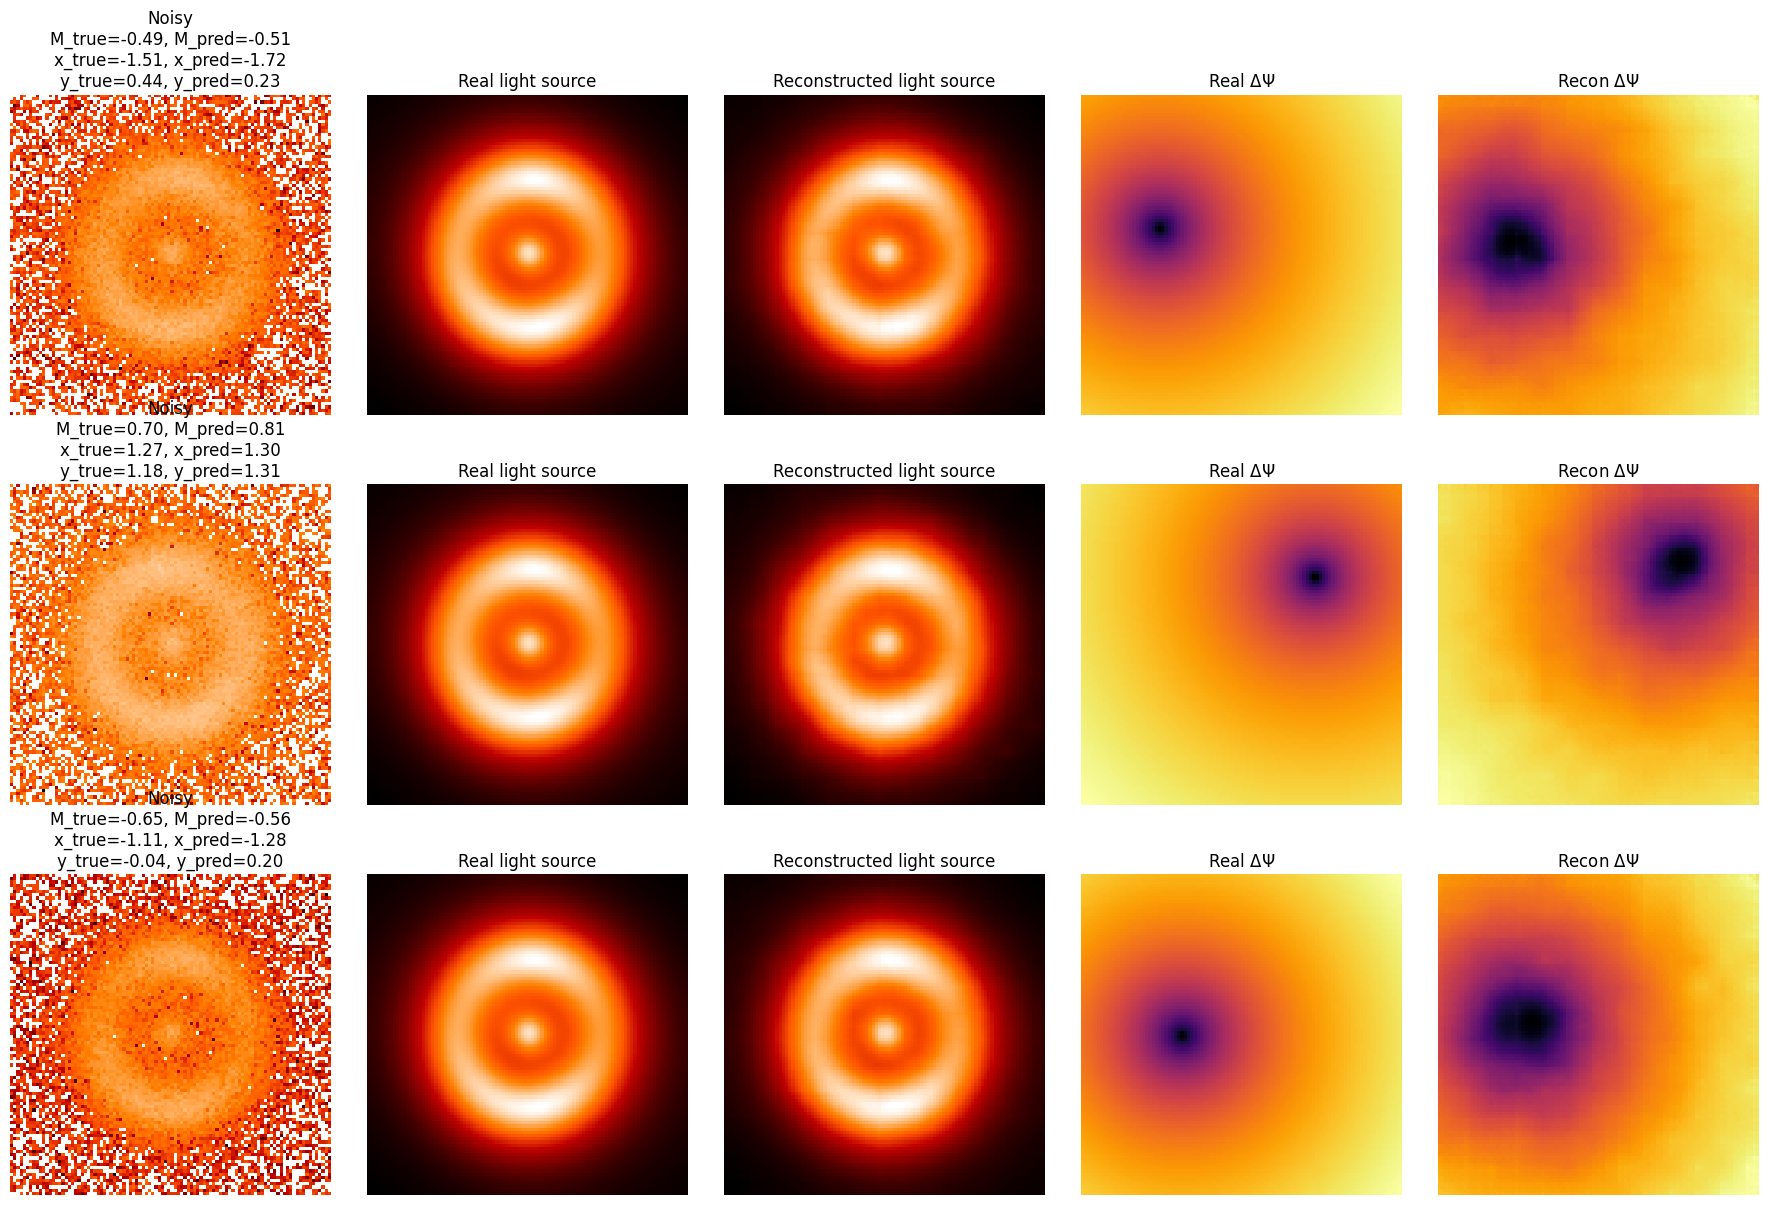

In [59]:
# 1) Saca un batch del test_loader e incluye mxy_true
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    # forward devuelve también mxy_pred
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# 2) Mueve todo a CPU + NumPy
x_np         = x.cpu().numpy()
y_true_s_np  = y_true_smooth.cpu().numpy()
y_true_d_np  = y_true_delta.cpu().numpy()
y_pred_s_np  = y_pred_smooth.cpu().numpy()
y_pred_d_np  = y_pred_delta.cpu().numpy()
mxy_true_np  = mxy_true.cpu().numpy()
mxy_pred_np  = mxy_pred.cpu().numpy()

# 3) Plot de N muestras del test set
n_samples = 3
offset    = 6   # ajusta para tomar otro inicio dentro del batch
fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4*n_samples))
for i in range(n_samples):
    idx = i + offset

    # extrae verdadero y predicho
    m_true, x_true, y_true = mxy_true_np[idx]
    m_pred, x_pred, y_pred = mxy_pred_np[idx]

    # Col 0: Entrada ruidosa
    ax = axes[i,0]
    ax.imshow(x_np[idx,0], origin='lower', cmap='gist_heat')
    ax.set_title(
        f"Noisy\n"
        f"M_true={m_true:.2f}, M_pred={m_pred:.2f}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real
    ax = axes[i,1]
    ax.imshow(y_true_s_np[idx,0], origin='lower', cmap='gist_heat')
    ax.set_title("Real light source")
    ax.axis('off')

    # Col 2: Smooth recon
    ax = axes[i,2]
    ax.imshow(y_pred_s_np[idx,0], origin='lower', cmap='gist_heat')
    ax.set_title("Reconstructed light source")
    ax.axis('off')

    # Col 3: Δψ real
    ax = axes[i,3]
    ax.imshow(y_true_d_np[idx,0], origin='lower', cmap='inferno')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon
    ax = axes[i,4]
    ax.imshow(y_pred_d_np[idx,0], origin='lower', cmap='inferno')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [60]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def compute_batch_psnr_ssim(x_true, x_pred):
    """
    x_true, x_pred: tensors PyTorch en [0,1], shape (N,1,H,W)
    Devuelven listas de PSNR y SSIM por muestra.
    """
    psnrs, ssims = [], []
    # convertimos a NumPy (N,H,W)
    t_true = x_true.cpu().numpy()[:, 0]
    t_pred = x_pred.cpu().numpy()[:, 0]
    for i in range(t_true.shape[0]):
        img_t = t_true[i]
        img_p = t_pred[i]
        psnrs.append( peak_signal_noise_ratio(img_t, img_p, data_range=1.0) )
        # full=False si solo queremos la media
        ssims.append( structural_similarity(img_t, img_p, data_range=1.0) )
    return psnrs, ssims

# Ejemplo de uso:
x_pred, x_true = y_pred_smooth, y_true_smooth  # tensores (N,1,H,W) normalizados en [0,1]
psnrs, ssims = compute_batch_psnr_ssim(x_true, x_pred)
print(f"PSNR (mean): {np.mean(psnrs):.2f} dB, SSIM (mean): {np.mean(ssims):.4f}")


PSNR (mean): 32.40 dB, SSIM (mean): 0.9841


MASS  MSE=0.0173, MAE=0.0884,  R²=0.9817
XPOS  MSE=0.0605, MAE=0.1740,  R²=0.9410
YPOS  MSE=0.0388, MAE=0.1378,  R²=0.9596


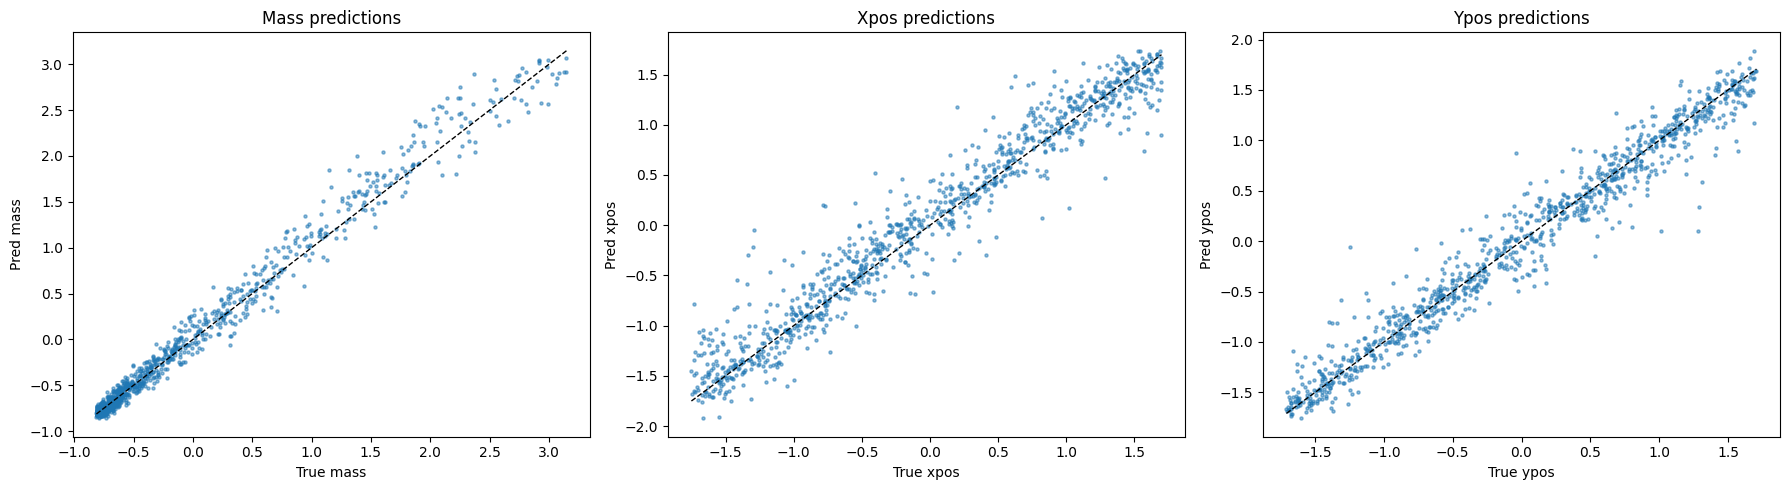

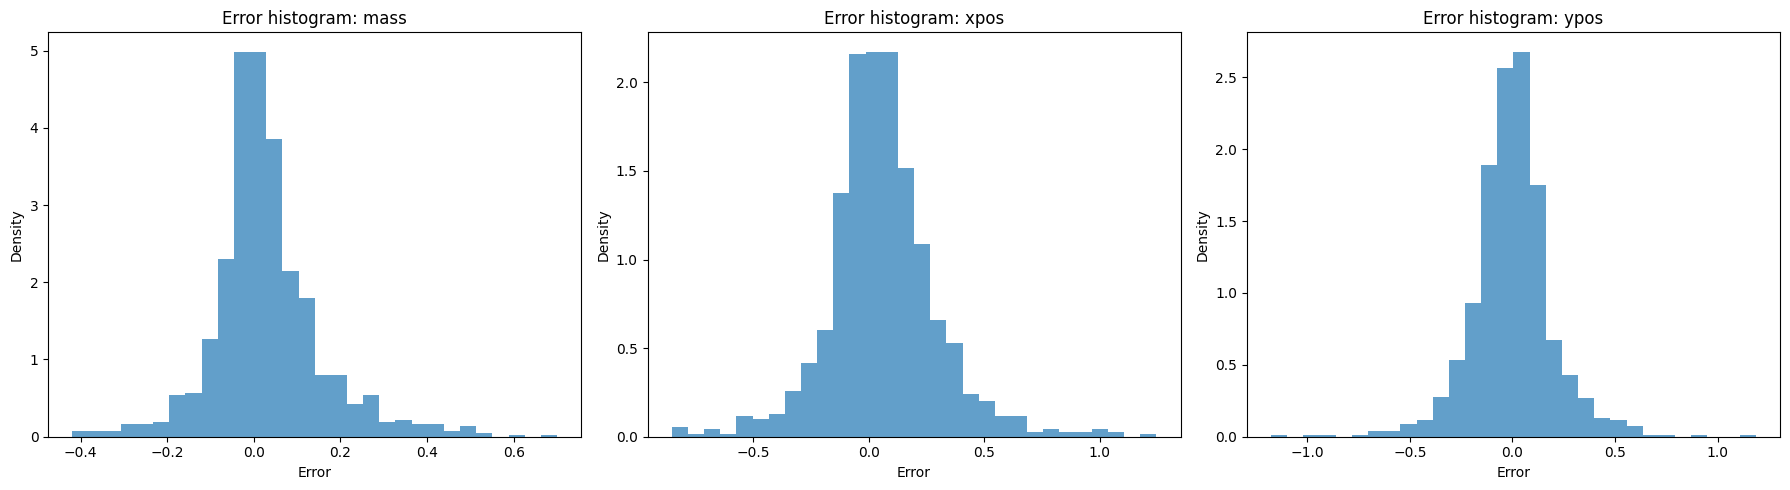

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Recorre el test_loader y guarda predicciones vs reales
model.eval()
all_pred = []
all_true = []

with torch.no_grad():
    for x, y_s, y_d, mxy_true in test_loader:
        x = x.to(device)
        # forward devuelve también mxy_pred
        _, _, _, _, mxy_pred = model(x)
        all_pred.append(mxy_pred.cpu().numpy())
        all_true.append(mxy_true.numpy())

all_pred = np.vstack(all_pred)  # shape (N_test, 3)
all_true = np.vstack(all_true)  # shape (N_test, 3)

# 2) Calcula métricas por componente
names = ['mass', 'xpos', 'ypos']
for i, name in enumerate(names):
    y_t = all_true[:, i]
    y_p = all_pred[:, i]
    mse = mean_squared_error(y_t, y_p)
    mae = mean_absolute_error(y_t, y_p)
    r2  = r2_score(y_t, y_p)
    print(f"{name.upper():>4}  MSE={mse:.4f}, MAE={mae:.4f},  R²={r2:.4f}")

# 3) Scatter plots (predicho vs real)
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, name in enumerate(names):
    axes[i].scatter(all_true[:,i], all_pred[:,i], s=5, alpha=0.5)
    axes[i].plot([all_true[:,i].min(), all_true[:,i].max()],
                 [all_true[:,i].min(), all_true[:,i].max()],
                 'k--', lw=1)
    axes[i].set_xlabel(f"True {name}")
    axes[i].set_ylabel(f"Pred {name}")
    axes[i].set_title(f"{name.title()} predictions")
plt.tight_layout()
plt.show()

# 4) Histograma de errores
errors = all_pred - all_true
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, name in enumerate(names):
    axes[i].hist(errors[:,i], bins=30, density=True, alpha=0.7)
    axes[i].set_title(f"Error histogram: {name}")
    axes[i].set_xlabel("Error")
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()
